In [2]:
import os
import sys
import csv

sys.path.append('..')

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import argparse as ap
import dan.data as ut
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from dan.embedding import EmbeddingTransformer
from dan.disguise import Disguise
from dan.discriminator import Discriminator
from dan.dan import DAN
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

sns.set(context='poster', style='whitegrid')

os.environ['CUDA_VISIBLE_DEVICES'] = "7"

%config InlineBackend.figure_format = 'retina'

SyntaxError: invalid syntax (embedding.py, line 38)

In [2]:
DATA_DIR = '../data/processed/mm-cpc'
TEST_CSV = 'test.csv'
JSON_NAME = 'index-cardinality.json'
# EXPERIMENT_DIR = '../models/dz-mm-cpc-embedded/256-0.5-0.2-2L/'
DISCRMINATOR_ARCHITECTURE = [64, 32]
DISGUISE_ARCHITECTURE = [256, 256, 256, 256]
LEARNING_RATE = 1e-5  
LAMBDA = 0.5 
ETA = 0.2

In [3]:
X_test, y_test = ut.load_data(
os.path.join(DATA_DIR, TEST_CSV),
target='conversion_target')
print('Test data has shape: ', X_test.shape)
print('Test labels has shape: ', y_test.shape)
num_features = X_test.shape[1]

Test data has shape:  (284492, 143)
Test labels has shape:  (284492, 2)


In [4]:
# Create embedding map
json_path = os.path.join(DATA_DIR, JSON_NAME)
index_cardinality_map = ut.load_cardinality_map(json_path)

In [5]:
! ls ../models/dz-mm-cpc-embedded/256-4-0.2-2L/

checkpoints  hyperparameters.txt  logs	test_results.csv


In [6]:
EXPERIMENT_DIRS = [
    '../models/dz-mm-cpc-embedded/256-4-0.2-2L/',
    '../models/dz-mm-cpc-embedded/256-0.5-0.2-2L/',
    '../models/dz-mm-cpc-embedded/256-0.3-0.2-2L/',
    '../models/dz-mm-cpc-embedded/baseline-64-32/',
]

In [7]:
pca_datas = list()
for EXPERIMENT_DIR in EXPERIMENT_DIRS: 
    checkpoint_dir = os.path.join(EXPERIMENT_DIR, 'checkpoints/')
    log_dir = os.path.join(EXPERIMENT_DIR, 'logs/')

    # Define DAN model
    tf.reset_default_graph()
    embedding_transformer = EmbeddingTransformer(index_cardinality_map)
    num_features_embedding = embedding_transformer.calc_num_outputs(num_features)
    print('Feature dimensionality in embedded space:', num_features_embedding)
    
    if 'baseline' in EXPERIMENT_DIR:
        disguise = None
    else:
        disguise = Disguise(num_features_embedding, DISGUISE_ARCHITECTURE)

    discriminator = Discriminator(DISCRMINATOR_ARCHITECTURE)
    dan = DAN(
        disguise, discriminator, checkpoint_dir, log_dir, embedding_transformer,
        num_inputs=num_features,
        learning_rate=LEARNING_RATE,
        lambd=LAMBDA,
        eta=ETA,
        early_stopping=4)
    
    x_input_placeholder = tf.placeholder(dtype=tf.float32, shape=(None, X_test.shape[1]))
    x_embedded_tensor = embedding_transformer(x_input_placeholder)
    x_embedded = dan.sess.run(x_embedded_tensor, feed_dict={x_input_placeholder: X_test})
    
    pca = PCA(n_components=2)
    x_pca = pca.fit_transform(x_embedded)
    print('Explained variances:', pca.explained_variance_ratio_)
    x_pca_neg = x_pca[y_test[:,0].astype(bool),:]
    x_pca_pos = x_pca[y_test[:,1].astype(bool),:]
    
    if 'baseline' not in EXPERIMENT_DIR:
        x_disguised = dan.transform(X_test)
        x_pca_disguised = pca.transform(x_disguised)
    else:
        x_pca_disguised = list()
    
    pca_data = dict(pos=x_pca_pos, neg=x_pca_neg, dis=x_pca_disguised)
    pca_datas.append(pca_data)
    
    del dan

Feature dimensionality in embedded space: 340


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Summary name cross entropy is illegal; using cross_entropy instead.
INFO:tensorflow:Summary name predictive entropy is illegal; using predictive_entropy instead.
INFO:tensorflow:Summary name discriminator loss is illegal; using discriminator_loss instead.
INFO:tensorflow:Summary name disguise quality is illegal; using disguise_quality instead.
INFO:tensorflow:Summary name disguise success rate is illegal; using disguise_success_rate instead.
INFO:tensorflow:Summary name disguise loss is illegal; using disguise_loss instead.
INFO:tensorflow:Summary name train accuracy is illegal; using train_accuracy instead.
INFO:tensorflow:Summary name train auroc is illegal; using train_auroc instead.
INFO:tensorflow:Summary name validation accuracy is illegal; using validation_accuracy instead.
INFO:tensorflow:Summary name validation auroc is illegal; using validation_auroc instead.
INFO:tensorflow:Restoring parameters from ../models/dz-mm-cpc-embedded/256-4-0.2-2L/checkpoints/-62903

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Summary name cross entropy is illegal; using cross_entropy instead.
INFO:tensorflow:Summary name predictive entropy is illegal; using predictive_entropy instead.
INFO:tensorflow:Summary name discriminator loss is illegal; using discriminator_loss instead.
INFO:tensorflow:Summary name disguise quality is illegal; using disguise_quality instead.
INFO:tensorflow:Summary name disguise success rate is illegal; using disguise_success_rate instead.
INFO:tensorflow:Summary name disguise loss is illegal; using disguise_loss instead.
INFO:tensorflow:Summary name train accuracy is illegal; using train_accuracy instead.
INFO:tensorflow:Summary name train auroc is illegal; using train_auroc instead.
INFO:tensorflow:Summary name validation accuracy is illegal; using validation_accuracy instead.
INFO:tensorflow:Summary name validation auroc is illegal; using validation_auroc instead.
INFO:tensorflow:Restoring parameters from ../models/dz-mm-cpc-embedded/256-0.5-0.2-2L/checkpoints/-449

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Summary name cross entropy is illegal; using cross_entropy instead.
INFO:tensorflow:Summary name predictive entropy is illegal; using predictive_entropy instead.
INFO:tensorflow:Summary name discriminator loss is illegal; using discriminator_loss instead.
INFO:tensorflow:Summary name disguise quality is illegal; using disguise_quality instead.
INFO:tensorflow:Summary name disguise success rate is illegal; using disguise_success_rate instead.
INFO:tensorflow:Summary name disguise loss is illegal; using disguise_loss instead.
INFO:tensorflow:Summary name train accuracy is illegal; using train_accuracy instead.
INFO:tensorflow:Summary name train auroc is illegal; using train_auroc instead.
INFO:tensorflow:Summary name validation accuracy is illegal; using validation_accuracy instead.
INFO:tensorflow:Summary name validation auroc is illegal; using validation_auroc instead.
INFO:tensorflow:Restoring parameters from ../models/dz-mm-cpc-embedded/256-0.3-0.2-2L/checkpoints/-419

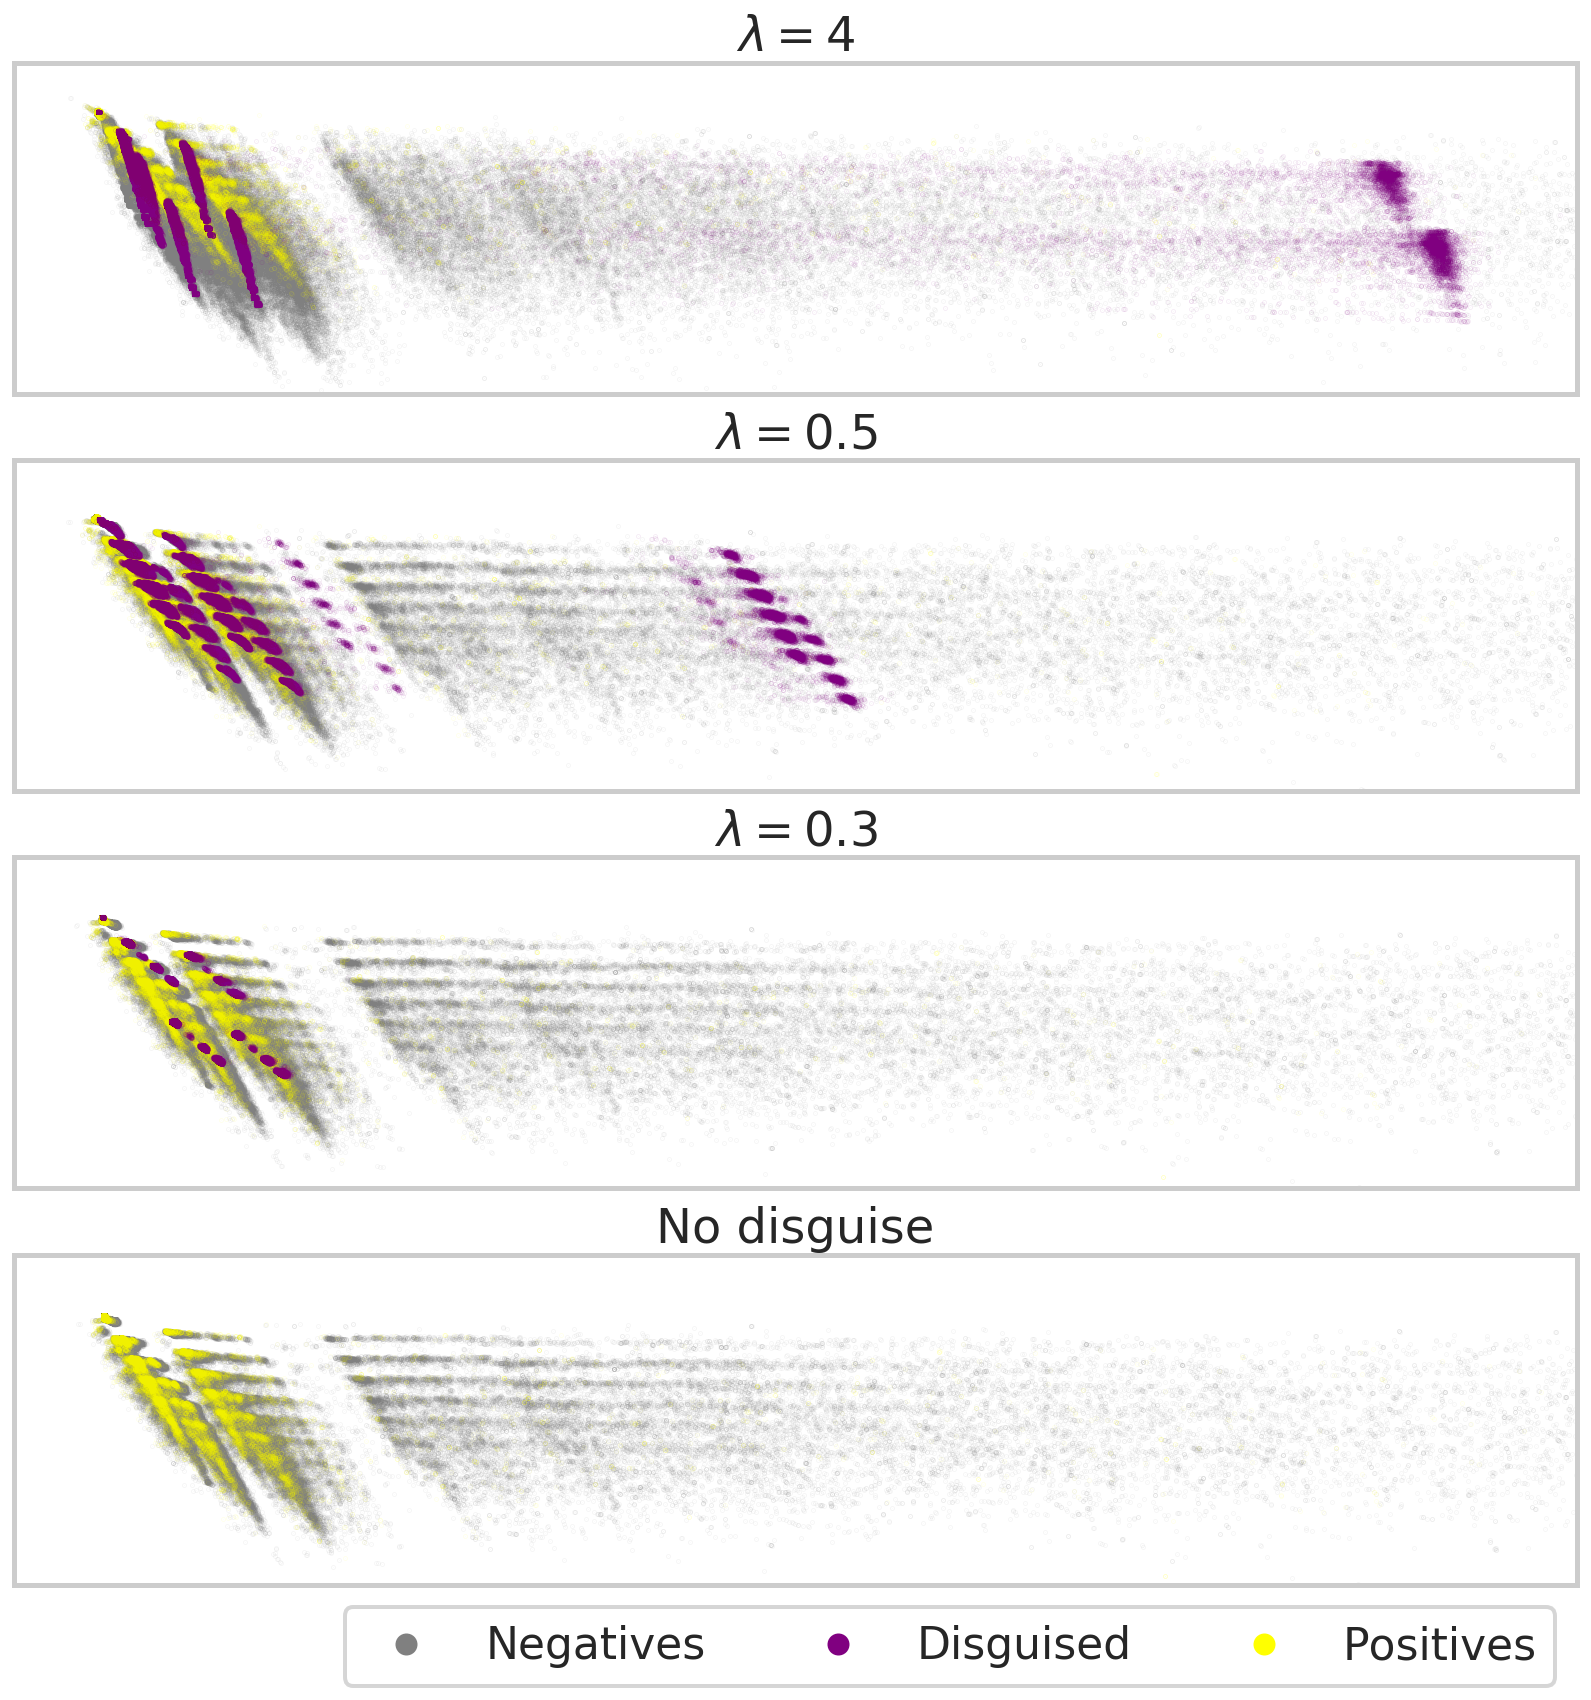

In [15]:
lambdas = [4, 0.5, 0.3]
fig, axes = plt.subplots(len(pca_datas), 1, figsize=(14, 14))
for ax, pca_data, lambd in zip(axes[:-1], pca_datas[:-1], lambdas):
    ax.scatter(pca_data['neg'][:,0], pca_data['neg'][:,1],
               color='gray', s=0.1, alpha=0.1, label='Negatives')
    ax.scatter(pca_data['pos'][:,0], pca_data['pos'][:,1],
               color='yellow', s=0.1, alpha=0.1, label='Positives')
    ax.scatter(pca_data['dis'][:,0], pca_data['dis'][:,1],
               color='purple', s=0.1, alpha=0.1, label='Disguised')
    ax.set_xlim(-1.5, 6)
    ax.set_ylim(-10, 7)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('$\lambda={}$'.format(lambd))
    
neg = mlines.Line2D(
  [], [], color='gray', marker='o', linestyle='None', markersize=10, 
  label='Negatives')
dis = mlines.Line2D(
  [], [], color='yellow', marker='o', linestyle='None', markersize=10,
  label='Positives')
pos = mlines.Line2D(
  [], [], color='purple', marker='o', linestyle='None', markersize=10,
  label='Disguised')

axes[-1].scatter(pca_datas[-1]['neg'][:,0], pca_datas[-1]['neg'][:,1],
           color='gray', s=0.1, alpha=0.1, label='Negatives')
axes[-1].scatter(pca_datas[-1]['pos'][:,0], pca_datas[-1]['pos'][:,1],
           color='yellow', s=0.1, alpha=0.1, label='Positives')
axes[-1].set_xlim(-1.5, 6)
axes[-1].set_ylim(-10, 7)
axes[-1].get_xaxis().set_visible(False)
axes[-1].get_yaxis().set_visible(False)
axes[-1].set_title('No disguise')

axes[-1].legend(handles=[neg, pos, dis], bbox_to_anchor=(1, 0), ncol=3)